In [1]:
import torch, gc, inspect, transformers
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from accelerate.utils import set_seed
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

transformers.logging.set_verbosity_warning()

/home/jonathan/miniconda3/envs/cu118/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/jonathan/miniconda3/envs/cu118/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
device = "cuda"

# Measuring Memory

In [3]:
def cleanup():
    """Free up memory and reset stats"""
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)
cleanup()

In [4]:
def print_memory_stats():
    """Print two different measures of GPU memory usage"""
    print(f"Max memory allocated: {torch.cuda.max_memory_allocated(device)/1e9:.2f}GB")
    # reserved (aka 'max_memory_cached') is ~the allocated memory plus pre-cached memory
    print(f"Max memory reserved: {torch.cuda.max_memory_reserved(device)/1e9:.2f}GB") 
print_memory_stats()

Max memory allocated: 0.00GB
Max memory reserved: 0.00GB


In [5]:
# QLoRA Forward + Backward pass

cleanup() # Clean slate each time

# Quantization config for QLoRA versions
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load the model
model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    low_cpu_mem_usage=True,
    quantization_config=bnb_config,
    use_cache=False
)

# This function has caused me lots of pain!
model = prepare_model_for_kbit_training(model)

# Add LoRA
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, config)

# Move to GPU
model.to(device)

# Prepare the data
bs, ctx = 1, 1200 # batch size and context length
data = torch.randint(0, 10000, (bs, ctx), device=device)

# Forward pass
output = model(data, labels=data)

# Backward pass
output.loss.backward()

# Print max memory stats
print_memory_stats()

# Cleanup
del model, output, data
cleanup()

/home/jonathan/miniconda3/envs/cu118/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Max memory allocated: 6.46GB
Max memory reserved: 7.11GB


## Exercise: Memory Usage vs Context Length

Pick a few different context lengths and see if you can plot the memory usage vs context length:

In [6]:
# Exercise solution
context_lengths = [1, 10, 100, 1000, 4000]
mems = []
for ctx in context_lengths:

    cleanup() # Clean slate each time
    model = AutoModelForCausalLM.from_pretrained(
        "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
        low_cpu_mem_usage=True,
        quantization_config=bnb_config,
        use_cache=False
    )
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, config)
    model.to(device)
    data = torch.randint(0, 10000, (1, ctx), device=device)
    output = model(data, labels=data)
    output.loss.backward()
    mems.append(torch.cuda.max_memory_allocated(device)/1e9)
    del model, output, data
    cleanup()

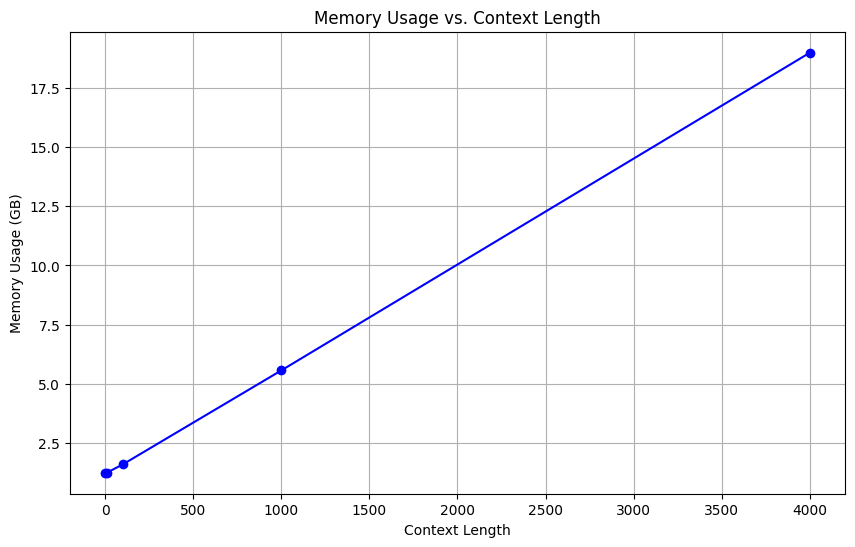

In [7]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(context_lengths, mems, marker='o', linestyle='-', color='b')
plt.title('Memory Usage vs. Context Length')
plt.xlabel('Context Length')
plt.ylabel('Memory Usage (GB)')
plt.grid(True)
plt.show()

## Memory History

We can go a lot further than just looking at the max memory usage, using PyTorch's [memory snapshots](https://pytorch.org/docs/stable/torch_cuda_memory.html#torch-cuda-memory). Here's how to log the memory usage in a format that can then be visualized:

In [8]:
cleanup()

# Load the model
model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    low_cpu_mem_usage=True,
    quantization_config=bnb_config,
    use_cache=False
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, config)
model.to(device)

# Prep the data
data = torch.randint(0, 10000, (1, 1000), device=device)

# Start recording
torch.cuda.memory._record_memory_history()

# FOrward and backwards pass
output = model(data, labels=data)
output.loss.backward()

# Save the snapshot and stop recording
torch.cuda.memory._dump_snapshot("memory_snapshot.pickle")
torch.cuda.memory._record_memory_history(enabled=None) 

# Clean up
del model, output, data
cleanup()

/home/jonathan/miniconda3/envs/cu118/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Viewing the results in [https://pytorch.org/memory_viz](https://pytorch.org/memory_viz) looks something like this:

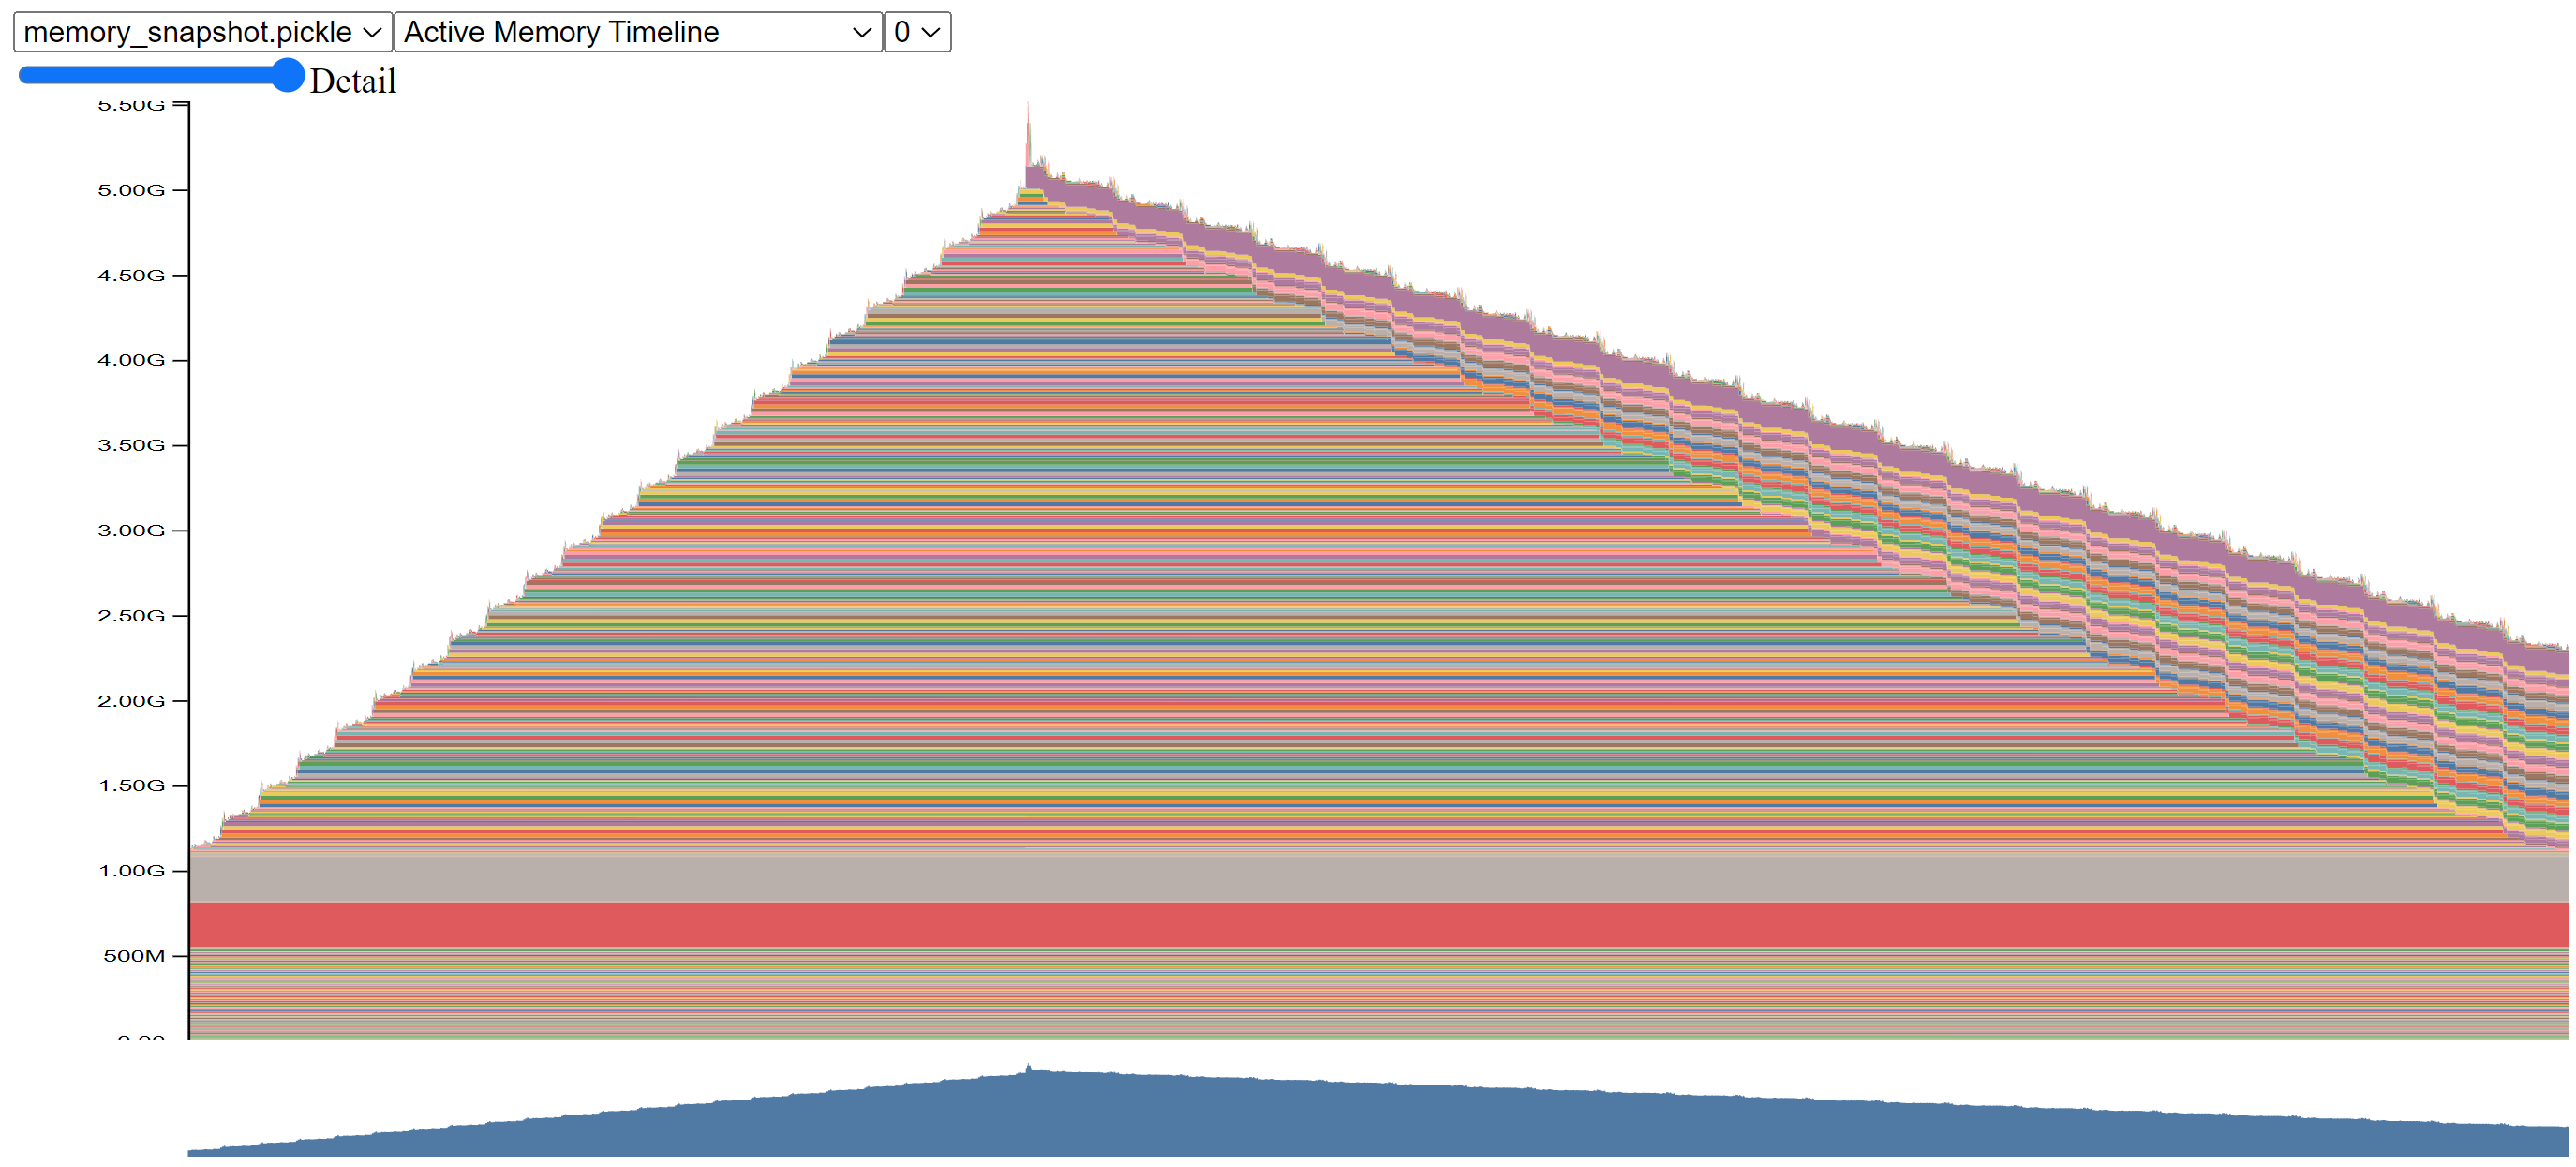

In [9]:
# This is what `model` looks like:
# LlamaForCausalLM(
#   (model): LlamaModel(
#     (embed_tokens): Embedding(32000, 2048)
#     (layers): ModuleList(
#       (0-21): 22 x LlamaDecoderLayer(
#         (self_attn): LlamaSdpaAttention(
#           (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
#           (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
#           (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
#           (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
#           (rotary_emb): LlamaRotaryEmbedding()
#         )
#         (mlp): LlamaMLP(
#           (gate_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
#           (up_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
#           (down_proj): Linear4bit(in_features=5632, out_features=2048, bias=False)
#           (act_fn): SiLU()
#         )
#         (input_layernorm): LlamaRMSNorm()
#         (post_attention_layernorm): LlamaRMSNorm()
#       )
#     )
#     (norm): LlamaRMSNorm()
#   )
#   (lm_head): Linear(in_features=2048, out_features=32000, bias=False)
# )

## Exercise: Visualize the memory usage for more settings

- LoRA vs full fine-tuning
- Quantized vs bf16
- Different sequence lengths
- Gradient CHeckpointing on vs off

We can make an even smaller model to play with:

In [10]:
from transformers import LlamaForCausalLM, PretrainedConfig

In [11]:
cleanup()
print_memory_stats()

Max memory allocated: 0.02GB
Max memory reserved: 0.26GB


In [12]:
# Copied from llama 3 and adapted to be a lot smaller
config = {
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 8192,
  "model_type": "llama",
  "num_attention_heads": 16,
  "num_hidden_layers": 12,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_theta": 500000.0,
  "tie_word_embeddings": False,
  "torch_dtype": "bfloat16",
  "vocab_size": 10000,
  "attention_bias": False,
  "attention_dropout": 0.0,
  "rope_scaling": None,
}
model = LlamaForCausalLM(PretrainedConfig(**config))
model.to(device);
print_memory_stats()

Max memory allocated: 0.91GB
Max memory reserved: 0.92GB


In [13]:
del model
cleanup()
print_memory_stats()

Max memory allocated: 0.02GB
Max memory reserved: 0.26GB
